# Tests for significance of difference between 0TEK0503244655 scores and all others

In [1]:
from pathlib import Path

import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load data into dataframe.

In [2]:
img_dir = Path('/home/michael/thesis/images/')

data = [
    {'tile': '10TEL0509245547', 'year': 2022, 'ROC AUC': 0.9714, 'Accuracy': 0.9315, 'Log Loss': 0.3583},
    {'tile': '10TDL0458245240', 'year': 2022, 'ROC AUC': 0.9953, 'Accuracy': 0.9836, 'Log Loss': 0.1878},
    {'tile': '10TEK0503244655', 'year': 2022, 'ROC AUC': 0.9156, 'Accuracy': 0.8444, 'Log Loss': 0.7774},
    {'tile': '10TDL0464245187', 'year': 2022, 'ROC AUC': 0.9959, 'Accuracy': 0.9858, 'Log Loss': 0.0598},
    {'tile': '10TDL0480045075', 'year': 2020, 'ROC AUC': 0.9833, 'Accuracy': 0.9976, 'Log Loss': 0.0499},
    {'tile': '10TDL0480045075', 'year': 2022, 'ROC AUC': 0.9977, 'Accuracy': 0.9820, 'Log Loss': 0.1009},
    {'tile': '10TDL0480045075', 'year': 2018, 'ROC AUC': None,  'Accuracy': 0.9451, 'Log Loss': None},
    {'tile': '10TEK0500244992', 'year': 2022, 'ROC AUC': 0.9996, 'Accuracy': 0.9887, 'Log Loss': 0.0503},
    {'tile': '10TDL0488245360', 'year': 2022, 'ROC AUC': 0.9990, 'Accuracy': 0.9859, 'Log Loss': 0.1460},
]

df = pd.DataFrame.from_dict(data)
df


,tile,year,ROC AUC,Accuracy,Log Loss
0,10TEL0509245547,2022,0.9714,0.9315,0.3583
1,10TDL0458245240,2022,0.9953,0.9836,0.1878
2,10TEK0503244655,2022,0.9156,0.8444,0.7774
3,10TDL0464245187,2022,0.9959,0.9858,0.0598
4,10TDL0480045075,2020,0.9833,0.9976,0.0499
5,10TDL0480045075,2022,0.9977,0.9820,0.1009
6,10TDL0480045075,2018,NaN,0.9451,NaN
7,10TEK0500244992,2022,0.9996,0.9887,0.0503
8,10TDL0488245360,2022,0.9990,0.9859,0.1460


### Test ROC AUC
Observe that the few pieces of data we have do not apear to be normally distributed.

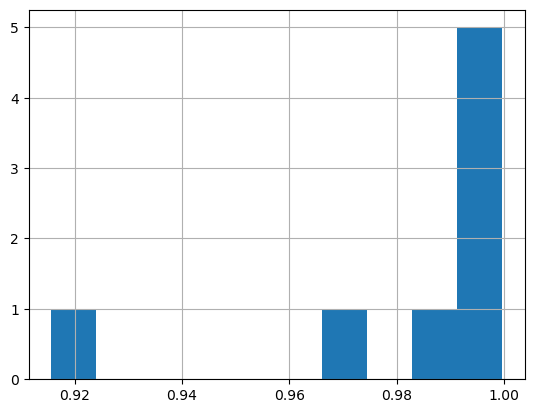

In [3]:
df['ROC AUC'].hist();

Get the ROC AUC values (dropping 10TDL0480045075, since it is NA)

In [4]:
# ROC AUC data, excluding 10TEK0503244655
data_roc_auc = df['ROC AUC'].dropna().values
data_roc_auc

array([0.9714, 0.9953, 0.9156, 0.9959, 0.9833, 0.9977, 0.9996, 0.999 ])

Calculate Robust Z-Score.  If the absolute value of the score is much more than 1, one would think of the value as an outlier.

Huber, Peter J., and E. M. Ronchetti. _Robust statistics. 2nd john wiley & sons._ Hoboken, NJ 2 (2009).

In [5]:
data = data_roc_auc

#  Median Absolute Deviation (MAD)
median_value = np.median(data)
mad_value = np.median(np.abs(data - median_value))

# 10TEK0503244655 ROC AUC
target_value_roc = df[df.tile == '10TEK0503244655']['ROC AUC'].values[0]

#robust Z-score 
robust_z_score_roc = 0.6745 * (target_value_roc - median_value) / mad_value

print("Robust Z-score:", robust_z_score_roc)

Robust Z-score: -14.583783783783872


The score strongly suggests it's an outlier!  The score for 10TEK0503244655 is more than 17 times the median absolute deviation (MAD) below the central tendency, as measured by the median.

Now let's do a Bayesian test (even though it is not normal, we will use a normal distribution in this case.  It is possible the distribution would be normal with more data, so we will test that case.)

In [6]:
# model
with pm.Model() as model:
    # Prior
    mu = pm.Uniform('mu', lower=0, upper=1)
    sigma = pm.HalfNormal('sigma', tau=1 / 0.1**2)
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, tau=1 / sigma**2, observed=data_roc_auc)
    
    # Posterior
    trace = pm.sample(10000, tune=2000)

# Now we can look at the posterior predictive distribution to see how likely 0.9184 is, given the data
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 11 seconds.
/home/michael/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [observed]


In [7]:
draws_roc = posterior_predictive['posterior_predictive'].observed.to_numpy().flatten()
devs_roc = abs(target_value_roc - draws_roc.mean()) / draws_roc.std()

f'Target is {devs_roc:.2f} standard deviations from the mean!' 

'Target is 1.73 standard deviations from the mean!'

## Test Accuracy

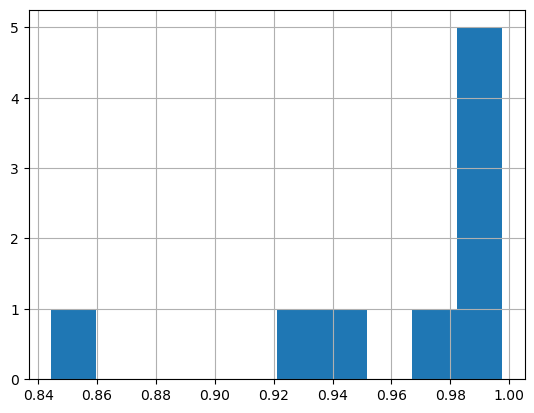

In [8]:
df.Accuracy.hist();

In [9]:
# Accuracy data
data = df.Accuracy.dropna().values

#  Median Absolute Deviation (MAD)
median_value = np.median(data)
mad_value = np.median(np.abs(data - median_value))

# 10TEK0503244655 Accuracy
target_value_acc = df[df.tile == '10TEK0503244655'].Accuracy.values[0]

#robust Z-score 
robust_z_score_acc = 0.6745 * (target_value_acc - median_value) / mad_value

print("Robust Z-score:", robust_z_score_acc)


Robust Z-score: -18.4098823529412


In [10]:
# model
with pm.Model() as model:
    # Prior
    mu = pm.Uniform('mu', lower=0, upper=1)
    sigma = pm.HalfNormal('sigma', tau=1 / 0.1**2)
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, tau=1 / sigma**2, observed=data)
    
    # Posterior
    trace = pm.sample(10000, tune=2000)

# Now we can look at the posterior predictive distribution to see how likely 0.9184 is, given the data
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

values = posterior_predictive['observed_data']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 9 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [observed]


In [11]:
draws_acc = posterior_predictive['posterior_predictive'].observed.to_numpy().flatten()
devs_acc = abs(target_value_acc - draws_acc.mean()) / draws_acc.std()

f'Target is {devs_acc:.2f} standard deviations from the mean!' 

'Target is 1.89 standard deviations from the mean!'

### Test Log-loss

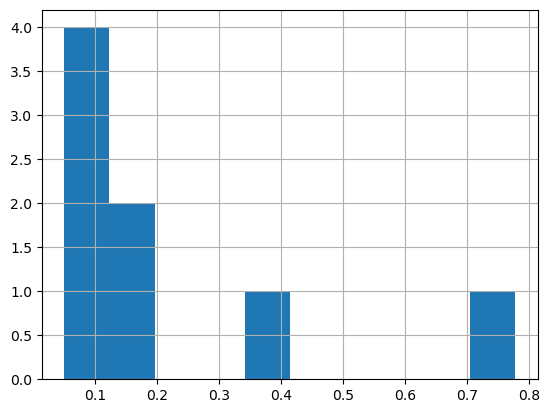

In [12]:
df['Log Loss'].dropna().hist();

In [13]:
# Accuracy data, excluding 10TEK0503244655
data = df['Log Loss'].dropna().values

#  Median Absolute Deviation (MAD)
median_value = np.median(data)
mad_value = np.median(np.abs(data - median_value))

# 10TEK0503244655 Accuracy
target_value_loss = df[df.tile == '10TEK0503244655'].Accuracy.values[0]

#robust Z-score 
robust_z_score_loss = 0.6745 * (target_value_loss - median_value) / mad_value

print("Robust Z-score:", robust_z_score_loss)

Robust Z-score: 7.073174909090908


In [14]:
# model
with pm.Model() as model:
    # Prior
    mu = pm.Uniform('mu', lower=0, upper=1)
    sigma = pm.HalfNormal('sigma', tau=1 / 0.1**2)
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, tau=1 / sigma**2, observed=data_roc_auc)
    
    # Posterior
    trace = pm.sample(10000, tune=2000)

# Now we can look at the posterior predictive distribution to see how likely 0.9184 is, given the data
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 10 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [observed]


In [15]:
draws_loss = posterior_predictive['posterior_predictive'].observed.to_numpy().flatten()
devs_loss = abs(target_value_loss - draws_loss.mean()) / draws_loss.std()

f'Target is {devs_loss:.2f} standard deviations from the mean!' 

'Target is 3.61 standard deviations from the mean!'

## Test to see if any other tiles are outliers

Only using accuracy.  We will use a truncated normal distribution with mu at 0.95.

In [47]:
def hdi(samples, credible_mass=0.95):
    sorted_samples = np.sort(samples)
    ci_idx_inc = int(np.ceil(credible_mass * len(sorted_samples)))
    n_ci = len(sorted_samples) - ci_idx_inc
    ci_width = sorted_samples[ci_idx_inc:] - sorted_samples[:n_ci]

    best_idx = np.argmin(ci_width)
    hdi_min = sorted_samples[best_idx]
    hdi_max = sorted_samples[best_idx + ci_idx_inc]
    return hdi_min, hdi_max


# Bayesian model
with pm.Model() as model:
    
    # priors
    mu = pm.TruncatedNormal(
        'mu',
        mu=0.99, 
        sigma=0.02, 
        lower=0, 
        upper=1)
    
    tau = pm.HalfNormal('tau' mu=0.025, sigma=0.005)
    
    # normal likelihood, with bounds
    observed = pm.TruncatedNormal(
        'observed',
        mu=mu,
        tau=tau,
        lower=0,
        upper=1,
        observed=data
        )
    
    # posterior
    trace = pm.sample(20000, tune=2000, cores=16)

# posterior predictive distribution
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

draws = posterior_predictive['posterior_predictive'].observed.to_numpy().flatten()
hdi_min, hdi_max = hdi(draws)


results = []
for tile in df.tile.values:
    data = df[df != tile].Accuracy.dropna().values
    
    #  Median Absolute Deviation (MAD)
    median_value = np.median(data)
    mad_value = np.median(np.abs(data - median_value))

    # tile Accuracy
    target_value = df[df.tile == tile].Accuracy.values[0]

    #robust Z-score 
    robust_z_score = 0.6745 * (target_value - median_value) / mad_value

    
    
    devs = abs(target_value - draws.mean()) / draws.std()

    results.append(
        {
            'tile': tile,
            'Accuracy': target_value,
            'Robust Z-score': robust_z_score,
            'Within 95%': (hdi_min <= target_value <=hdi_max)
        }
    )    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, tau]


Sampling 16 chains for 2_000 tune and 20_000 draw iterations (32_000 + 320_000 draws total) took 42 seconds.
There were 498 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [observed]


In [48]:
results_df = pd.DataFrame.from_dict(results)
results_df

,tile,Accuracy,Robust Z-score,Within 95%
0,10TEL0509245547,0.9315,-6.890480,True
1,10TDL0458245240,0.9836,0.000000,False
2,10TEK0503244655,0.8444,-18.409882,True
3,10TDL0464245187,0.9858,0.290961,False
4,10TDL0480045075,0.9976,1.851569,False
5,10TDL0480045075,0.9976,1.851569,False
6,10TDL0480045075,0.9976,1.851569,False
7,10TEK0500244992,0.9887,0.674500,False
8,10TDL0488245360,0.9859,0.304186,False


## Summary

(array([1., 0., 0., 0., 0., 1., 1., 0., 1., 5.]),
 array([0.8444 , 0.85972, 0.87504, 0.89036, 0.90568, 0.921  , 0.93632,
        0.95164, 0.96696, 0.98228, 0.9976 ]),
 <BarContainer object of 10 artists>)

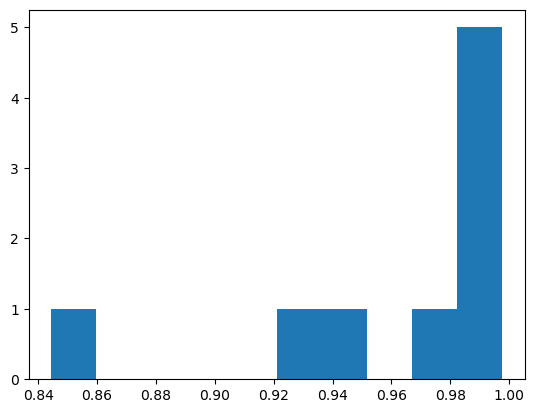

In [49]:
plt.hist(data)

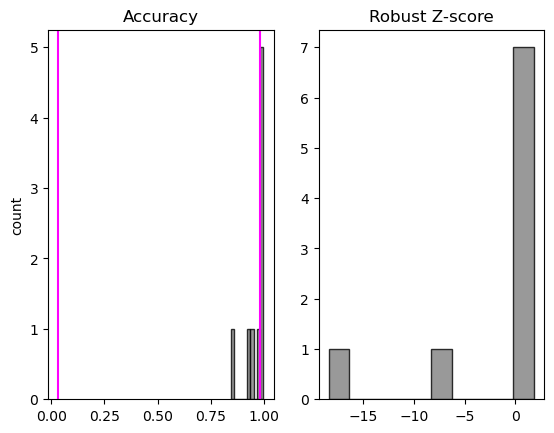

In [50]:
fig, [ax1, ax2] = plt.subplots(1,2)
_ = df['Accuracy'].hist(
    ax=ax1,
    edgecolor='k',
    facecolor='grey',
    alpha=0.8
)
ax1.set_title('Accuracy')
ax1.grid(visible=False)
ax1.set_ylabel('count')
ax1.axvline(x=hdi_min, c='magenta')
ax1.axvline(x=hdi_max, c='magenta')

_ = results_df['Robust Z-score'].hist(
    ax=ax2,
    edgecolor='k',
    facecolor='grey',
    alpha=0.8
)
ax2.set_title('Robust Z-score')
ax2.grid(visible=False)

plt.savefig(img_dir / 'significance.png')

In [19]:
results_df.to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n & tile & Accuracy & Robust Z-score & Within 95% \\\\\n\\midrule\n0 & 10TEL0509245547 & 0.931500 & -6.890480 & False \\\\\n1 & 10TDL0458245240 & 0.983600 & 0.000000 & False \\\\\n2 & 10TEK0503244655 & 0.844400 & -18.409882 & False \\\\\n3 & 10TDL0464245187 & 0.985800 & 0.290961 & False \\\\\n4 & 10TDL0480045075 & 0.997600 & 1.851569 & False \\\\\n5 & 10TDL0480045075 & 0.997600 & 1.851569 & False \\\\\n6 & 10TDL0480045075 & 0.997600 & 1.851569 & False \\\\\n7 & 10TEK0500244992 & 0.988700 & 0.674500 & False \\\\\n8 & 10TDL0488245360 & 0.985900 & 0.304186 & False \\\\\n\\bottomrule\n\\end{tabular}\n'

In [28]:
print(
    f'''
    Due to the small sample size (n=9 for accuracy, n=8 for ROC AUC and Log Loss) it is difficult to discern if there is significant difference between 10TEK0503244655 and the other tiles with regards to all three scores.  The Robust Z-score does not rely on an assumption of a normal distribution.  The Bayesian test does assume a normal distribution.  It would be expected that the scores for the tiles, if they are all from a dataset which is represented in the training data, should be normally distributed.  We do not however know the parameters of that distribution.  We can estimate them from the scores we have, but since there are so few we do not have that much confidence in our estimates, this lack of confidence should be reflected in likelihood of the Bayesian model.
    
    In the figure shown above the table, left:  Accuracy scores foe eac
    
    For ROC AUC  was {robust_z_score_roc:.2f}, indicating that the score for 10TEK0503244655 is more than 17 times the median absolute deviation (MAD) from the central tendency, as measured by the median.
    
    Using a b we find 10TEK0503244655 to be {devs_roc:.2f} standard
    deviations from the central tendency, as measured by the mean.
    
    For accuracy:
    robust z-score: {robust_z_score_acc:.2f}
    Bayesian test: {devs_acc:.2f}
    
    For log loss:
    robust z-score: {robust_z_score_loss:.2f}
    Bayesian test: {devs_loss:.2f}
    
    These are so far outside of the distributions, that even with the small samples, I think it is reasonable
    to view the differences as significant.
    '''
)


    Despite the small sample size (n=8 for accuracy, n=7 for ROC AUC and Log Loss) it seems that there
    is a significant difference between 10TEK0503244655 and the other tiles with regards to all three scores.
    For ROC AUC robust z-score (which does not rely on an assumption of a normal distribution) was
    -17.47, indicating that the score for 10TEK0503244655 is more than 17 times the median
    absolute deviation (MAD) from the central tendency, as measured by the median.
    
    Using a bayesian test (assuming a normal distribution) we find 10TEK0503244655 to be 4.99 standard
    deviations from the central tendency, as measured by the mean.
    
    For accuracy:
    robust z-score: -28.25
    Bayesian test: 4.11
    
    For log loss:
    robust z-score: 9.91
    Bayesian test: 9.73
    
    These are so far outside of the distributions, that even with the small samples, I think it is reasonable
    to view the differences as significant.
    
